#### Notebook for visualisation of gene programmes from `NicheCompass`

- **Developed by:** Carlos Talavera-López
- **Modified by**: 
- **Faculty of Medicine, University of Würzburg**
- **Creation Date:** 241010
- **Last modified**: 241010

### Load required modules

In [8]:
import ast
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from biomart import BiomartServer
from collections import defaultdict
from scipy.cluster import hierarchy
import matplotlib.colors as mcolors
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LinearSegmentedColormap

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.10.3
-----
PIL                         10.0.0
appnope                     0.1.3
asciitree                   NA
asttokens                   NA
attr                        23.1.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
biomart                     NA
certifi                     2023.07.22
charset_normalizer          3.2.0
cloudpickle                 2.2.1
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2024.8.0
dask_image                  2023.08.1
datashader                  0.15.2
datashape                   0.5.2
datatree                    0.0.12
dateutil                    2.8.2
debugpy                     1.6.7.post1
decorator                   5.1.1
docrep                      0.3.2
entrypoints                 0.4
exceptiongroup              1.1.3
executing                   1.2.0
fasteners                   0.

In [3]:
fig_dir = '../figures/'

### Read in `anndata` object

In [4]:
adata = sc.read_h5ad('../data/adata_results.h5ad')
adata

AnnData object with n_obs × n_vars = 25725 × 310
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'n_counts', 'cell_type', 'batch', 'latent_leiden_0.4', 'S100A1_ligand_receptor_GP', 'LIF_combined_GP', 'VWF_combined_GP', 'LPL_ligand_receptor_target_gene_GP', 'PRG4_ligand_receptor_target_gene_GP', 'MMRN2_ligand_receptor_target_gene_GP', 'ADAM28_ligand_receptor_target_gene_GP', 'Add-on_72_GP', 'ANGPT2_combined_GP', 'NTN4_combined_GP', 'EDN1_combined_GP', 'Add-on_42_GP', 'COL17A1_combined_GP', 'PECAM1_combined_GP', 'FBN1_ligand_receptor_target_gene_GP', 'Add-on_48_GP', 'CD274_combined_GP', 'GPC3_ligand_receptor_target_gene_GP', 'LILRB2_ligand_receptor_target_gene_GP', 'FBLN1_combined_GP', 'CD28_ligand_receptor_target_gene_GP', 'OGN_ligand_receptor_target_gene_GP', 'EPCAM_ligand_receptor_target_gene_GP', 'CXCL6_combined_

### Extract genes and gene weights from programme of interest

In [5]:
df = adata.uns['nichecompass_gp_summary']
df.head()

gp_name all_gp_idx gp_active active_gp_idx  \
0                 KIT_ligand_receptor_GP          0     False                 
1              S100A1_ligand_receptor_GP          1      True           0.0   
2  ADAM28_ligand_receptor_target_gene_GP          2      True           1.0   
3   ANPEP_ligand_receptor_target_gene_GP          3      True           2.0   
4   APOA5_ligand_receptor_target_gene_GP          4      True           3.0   

  n_source_genes n_non_zero_source_genes n_target_genes  \
0              1                       1              1   
1              1                       1              1   
2              1                       1             20   
3              1                       1             22   
4              1                       1             19   

  n_non_zero_target_genes gp_source_genes  \
0                       1             KIT   
1                       1          S100A1   
2                      20          ADAM28   
3                      22           ANPEP   
4                      19           APOA5   

                                     gp_target_genes gp_source_genes_weights  \
0                                               IL7R                 -0.0061   
1                                               AGER                 -2.0907   
2  FHL2, IGF1, CDK1, BAMBI, TNC, CAV1, MDM2, ESR1...                 -0.9988   
3  PRDM1, CAV1, CXCR4, FAS, EGFR, PPARG, CDK1, ST...                  0.0343   
4  ERBB2, STC2, MDM2, MYC, BCL2L11, TOP2A, PPARG,...                 -0.0176   

                             gp_target_genes_weights  \
0                                            -0.0053   
1                                             0.3525   
2  1.665, 0.441, -0.4258, 0.3317, -0.3086, 0.2545...   
3  -0.1318, 0.124, -0.1081, 0.1044, 0.0995, -0.09...   
4  0.1585, 0.0972, 0.0877, -0.0751, 0.0569, 0.045...   

  gp_source_genes_importances  \
0                      0.5346   
1                      0.8557   
2                      0.1643   
3                      0.0245   
4                      0.0219   

                         gp_target_genes_importances  
0                                             0.4654  
1                                             0.1443  
2  0.2739, 0.0726, 0.07, 0.0546, 0.0508, 0.0419, ...  
3  0.0939, 0.0884, 0.077, 0.0744, 0.0709, 0.0661,...  
4  0.1971, 0.1208, 0.1091, 0.0934, 0.0707, 0.0568...

### Prototype of opinion dynamics inference in spatial niches.

In [6]:
def create_opinion_matrix(adata, niche_label, gp_summary):
    """
    Create an opinion matrix for cells in a specific niche using gene programme activity.
    
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche to analyze
    :param gp_summary: DataFrame containing gene program summaries
    :return: DataFrame with cells as rows and gene programmes as columns
    """
    # Filter cells belonging to the specified niche
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label]
    
    print(f"Number of cells in niche {niche_label}: {niche_cells.n_obs}")
    
    # Get active gene programs
    gp_summary['gp_active'] = gp_summary['gp_active'].astype(bool)  # Ensure boolean type
    active_gps = gp_summary[gp_summary['gp_active']]['gp_name'].tolist()
    
    print(f"Number of active gene programmes: {len(active_gps)}")
    print("First few active gene programmes:", active_gps[:5])
    
    # Initialize opinion matrix
    opinion_matrix = pd.DataFrame(index=niche_cells.obs_names)
    
    # Fill opinion matrix with gene programme activity values
    for gp in active_gps:
        if gp in niche_cells.obs.columns:
            opinion_matrix[gp] = niche_cells.obs[gp]
        else:
            print(f"Warning: Gene programme {gp} not found in adata.obs")
    
    # Check for NaN values
    nan_count = opinion_matrix.isna().sum().sum()
    print(f"Number of NaN values in the opinion matrix: {nan_count}")
    
    # Replace NaN with 0 if any are found
    opinion_matrix = opinion_matrix.fillna(0)
    
    # Normalize opinions to be between 0 and 1
    for column in opinion_matrix.columns:
        min_val = opinion_matrix[column].min()
        max_val = opinion_matrix[column].max()
        if max_val > min_val:
            opinion_matrix[column] = (opinion_matrix[column] - min_val) / (max_val - min_val)
        else:
            opinion_matrix[column] = 0  # If all values are the same, set to 0
    
    return opinion_matrix

def spatial_weight_matrix(adata, niche_label):
    """
    Create a spatial weight matrix based on cell distances.
    
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche to analyze
    :return: DataFrame with spatial weights between cells
    """
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label]
    
    # Extract spatial coordinates
    spatial_coords = niche_cells.obsm['spatial']
    
    # Compute pairwise distances
    distances = pdist(spatial_coords)
    dist_matrix = squareform(distances)
    
    # Convert distances to weights (inverse distance)
    weights = 1 / (1 + dist_matrix)
    np.fill_diagonal(weights, 0)  # Set diagonal to 0
    
    return pd.DataFrame(weights, index=niche_cells.obs_names, columns=niche_cells.obs_names)

def update_opinions(opinions, weights, learning_rate=0.1):
    """
    Update cell opinions based on the weighted average of neighboring cells.
    
    :param opinions: DataFrame of current cell opinions
    :param weights: DataFrame of spatial weights between cells
    :param learning_rate: Rate at which opinions are updated
    :return: Updated opinion matrix
    """
    weighted_opinions = weights.dot(opinions)
    updated_opinions = opinions + learning_rate * (weighted_opinions - opinions)
    return updated_opinions

def run_opinion_dynamics(adata, niche_label, gp_summary, n_iterations=100):
    """
    Run the opinion dynamics model for a specific niche.
    
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche to analyze
    :param gp_summary: DataFrame containing gene program summaries
    :param n_iterations: Number of iterations to run the model
    :return: List of opinion matrices at each iteration
    """
    initial_opinions = create_opinion_matrix(adata, niche_label, gp_summary)
    weights = spatial_weight_matrix(adata, niche_label)
    
    opinion_history = [initial_opinions]
    
    current_opinions = initial_opinions.copy()
    for _ in range(n_iterations):
        current_opinions = update_opinions(current_opinions, weights)
        opinion_history.append(current_opinions)
    
    return opinion_history

def visualize_opinion_changes(initial_opinions, final_opinions, adata, niche_label):
    """
    Visualize the cells that changed their opinions the most, using clustermap without grid lines.
    Include information about all cell types in the niche.
    
    :param initial_opinions: DataFrame of initial cell opinions
    :param final_opinions: DataFrame of final cell opinions
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche being analyzed
    """
    opinion_change = (final_opinions - initial_opinions).abs().mean(axis=1)
    
    # Sort cells by the magnitude of opinion change
    top_changed_cells = opinion_change.sort_values(ascending=False).head(20)
    
    # Create a heatmap of opinion changes for top changed cells
    change_matrix = final_opinions.loc[top_changed_cells.index] - initial_opinions.loc[top_changed_cells.index]
    
    # Get cell types for all cells in the niche
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label]
    all_cell_types = niche_cells.obs['cell_type']
    
    # Create a color map for all cell types
    unique_cell_types = all_cell_types.unique()
    cell_type_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_cell_types)))
    cell_type_color_map = {ct: mcolors.rgb2hex(cell_type_colors[i][:3]) for i, ct in enumerate(unique_cell_types)}
    
    # Create row colors for the top changed cells
    row_colors = pd.DataFrame({'Cell Type': all_cell_types[all_cell_types.index.isin(change_matrix.index)]})
    row_colors = row_colors['Cell Type'].map(cell_type_color_map)
    
    # Create the clustermap
    g = sns.clustermap(change_matrix, cmap='RdPu', center=0, 
                       figsize=(20, 10), row_colors=row_colors,
                       dendrogram_ratio=(.1, .2), 
                       cbar_pos=(0.02, .2, .03, .4),
                       linewidths=0)  # Set linewidths to 0 to remove grid lines
    
    # Remove grid lines
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
    g.ax_heatmap.tick_params(axis='both', which='both', length=0, pad=8)
    g.ax_heatmap.grid(False)
    
    g.ax_heatmap.set_title(f'Opinion Changes for Top 20 Most Changed Cells in Niche {niche_label}')
    g.ax_heatmap.set_xlabel('Gene Programmes')
    g.ax_heatmap.set_ylabel('Cells')
    
    # Add a legend for all cell types
    for label, color in cell_type_color_map.items():
        g.ax_row_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
    g.ax_row_dendrogram.legend(title='Cell Types', loc='center', bbox_to_anchor=(0.5, 0.8), ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of cell type counts in the niche
    cell_type_counts = all_cell_types.value_counts()
    print(f"\nCell type counts in Niche {niche_label}:")
    for cell_type, count in cell_type_counts.items():
        print(f"{cell_type}: {count}")
    
    # Print cell types present in the top 20 changed cells
    top_20_cell_types = set(all_cell_types[all_cell_types.index.isin(change_matrix.index)])
    print(f"\nCell types present in the top 20 changed cells:")
    for cell_type in top_20_cell_types:
        print(cell_type)

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Number of cells in niche 0: 4354
Number of active gene programmes: 158
First few active gene programmes: ['KIT_ligand_receptor_GP', 'S100A1_ligand_receptor_GP', 'ADAM28_ligand_receptor_target_gene_GP', 'ANPEP_ligand_receptor_target_gene_GP', 'APOA5_ligand_receptor_target_gene_GP']
Number of NaN values in the opinion matrix: 0

Initial opinions (first 5 cells, first 5 gene programmes):
    S100A1_ligand_receptor_GP  ADAM28_ligand_receptor_target_gene_GP  \
30                   0.246639                               0.676015   
58                   0.295944                               0.630641   
59                   0.403755                               0.532062   
60                   0.312568                               0.634514   
61                   0.346822                               0.626219   

    ANPEP_ligand_receptor_target_gene_GP  \
30                              0.533395   
58                              0.829571   
59                              0.866435   
60 

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_78161/3232699653.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cell_type_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_cell_types)))
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_78161/3232699653.py:161: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_78161/3232699653.py:161: UserWarning: T

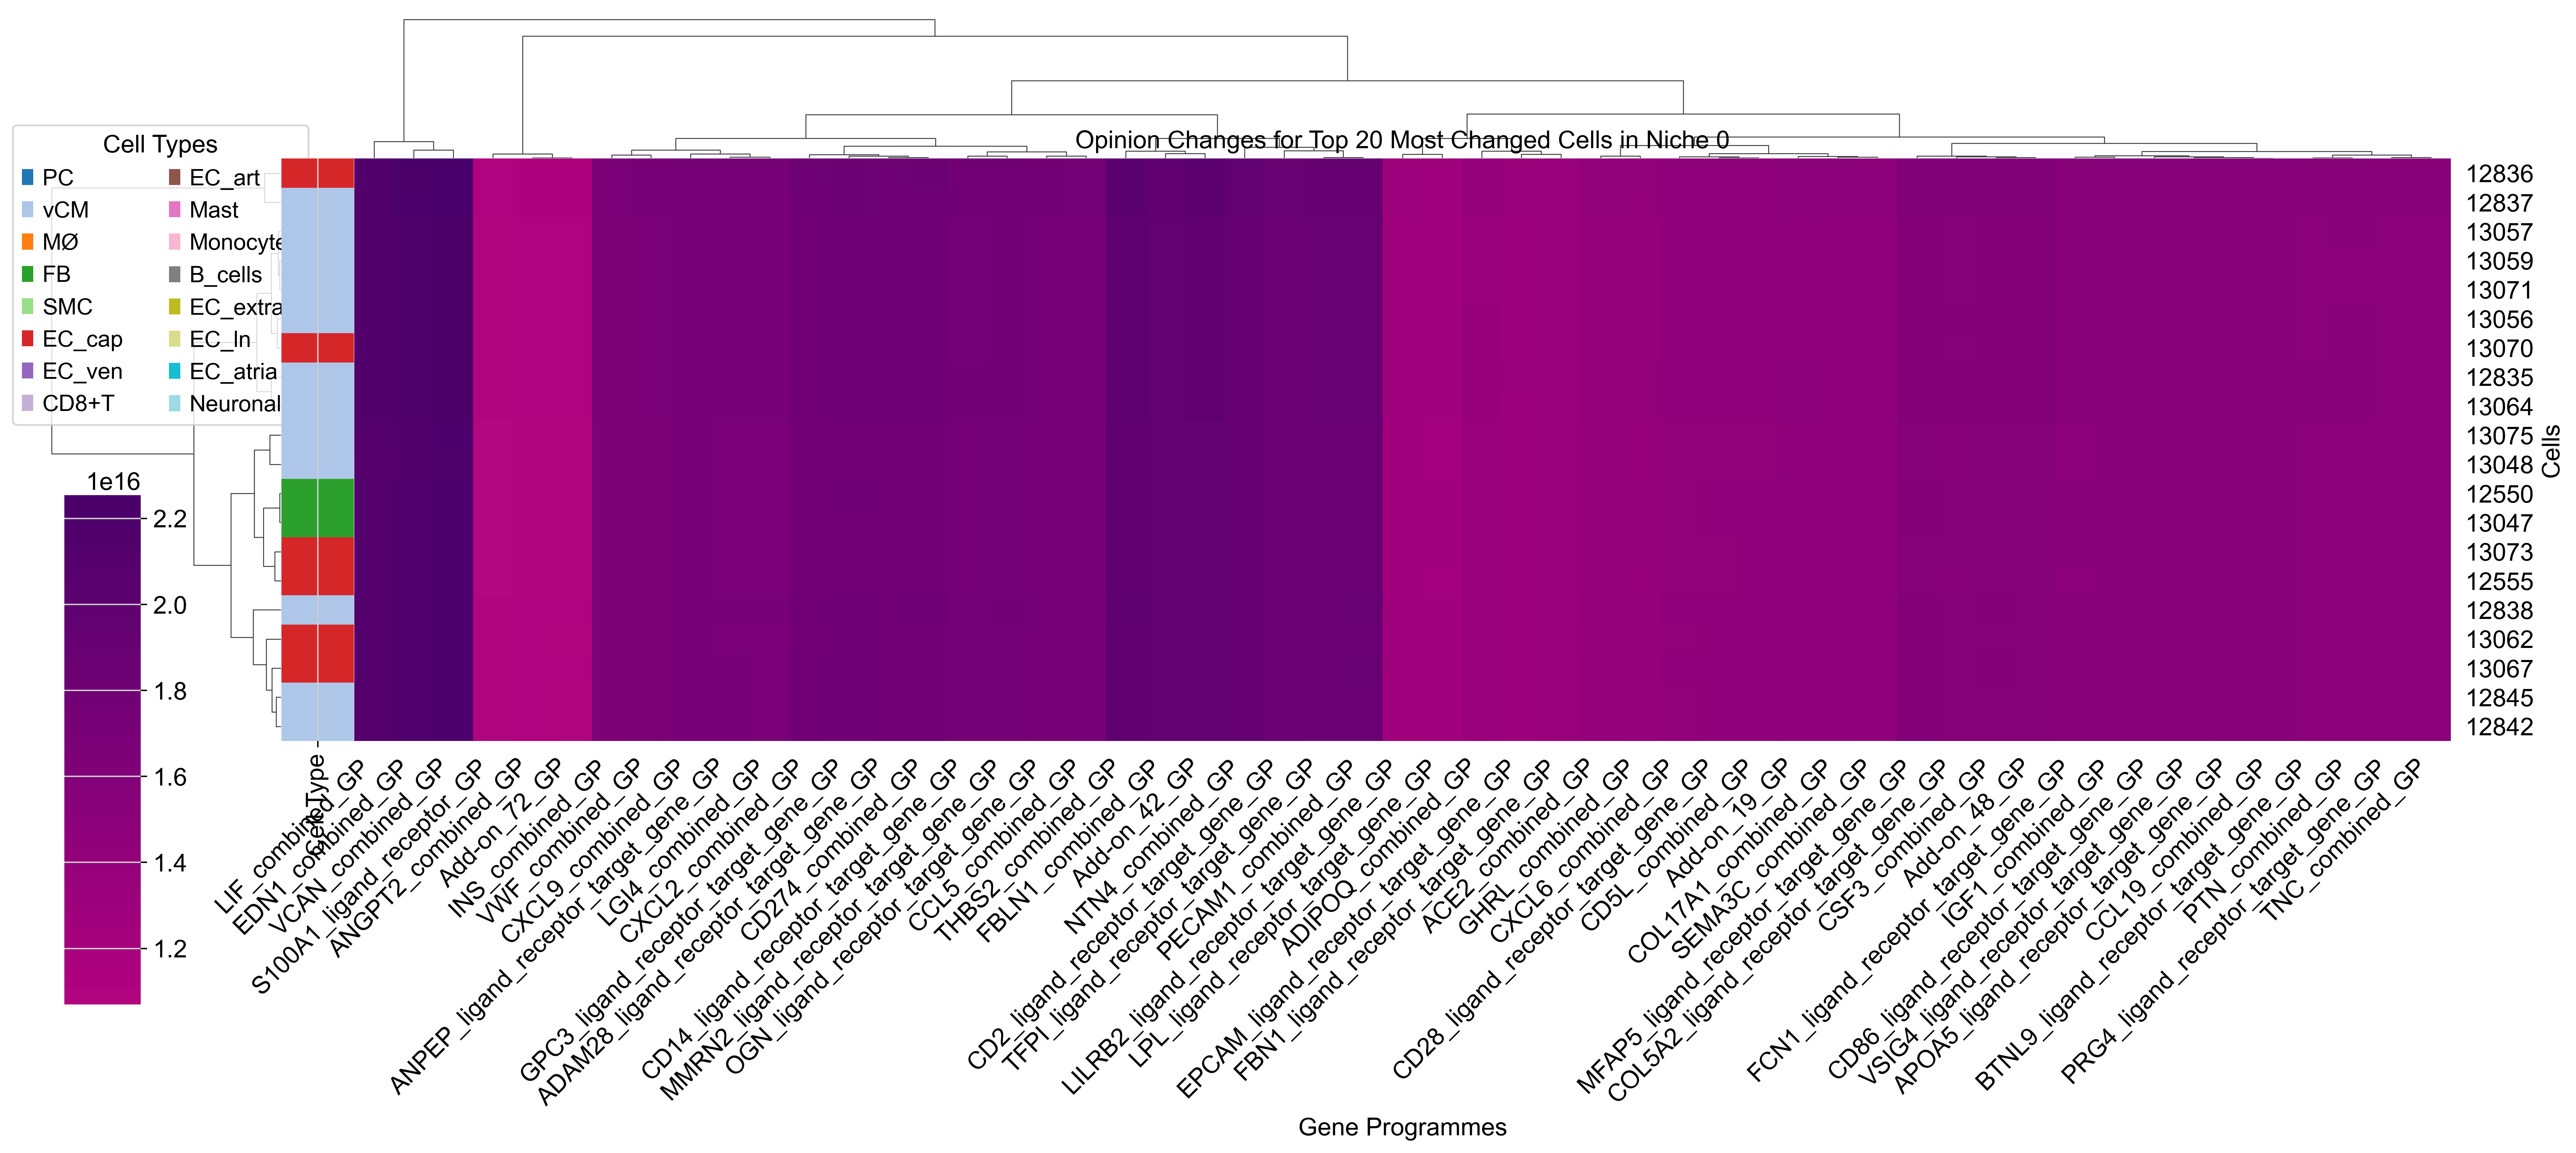


Cell type counts in Niche 0:
vCM: 3589
EC_cap: 301
FB: 256
PC: 97
MØ: 61
EC_ven: 23
EC_extra: 6
Monocytes: 5
CD8+T: 4
Mast: 3
EC_art: 2
EC_atria: 2
Neuronal: 2
B_cells: 1
EC_ln: 1
SMC: 1

Cell types present in the top 20 changed cells:
vCM
FB
EC_cap

Top 10 gene programmes with the most significant changes:


In [7]:
# Example usage
niche_label = "0"  # Replace with the desired niche label
opinion_history = run_opinion_dynamics(adata, niche_label, adata.uns['nichecompass_gp_summary'])

# Analyze results
initial_opinions = opinion_history[0]
final_opinions = opinion_history[-1]
opinion_change = final_opinions - initial_opinions

print("\nInitial opinions (first 5 cells, first 5 gene programmes):")
print(initial_opinions.iloc[:5, :5])
print("\nFinal opinions (first 5 cells, first 5 gene programmes):")
print(final_opinions.iloc[:5, :5])
print("\nOpinion changes (first 5 cells, first 5 gene programmes):")
print(opinion_change.iloc[:5, :5])

# Visualize opinion changes with improved formatting and cell type information
visualize_opinion_changes(initial_opinions, final_opinions, adata, niche_label)

# Additional analysis: Print top 10 gene programmes with the most significant changes
mean_change = opinion_change.abs().mean()
top_gps = mean_change.sort_values(ascending=False).head(10)
print("\nTop 10 gene programmes with the most significant changes:")

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


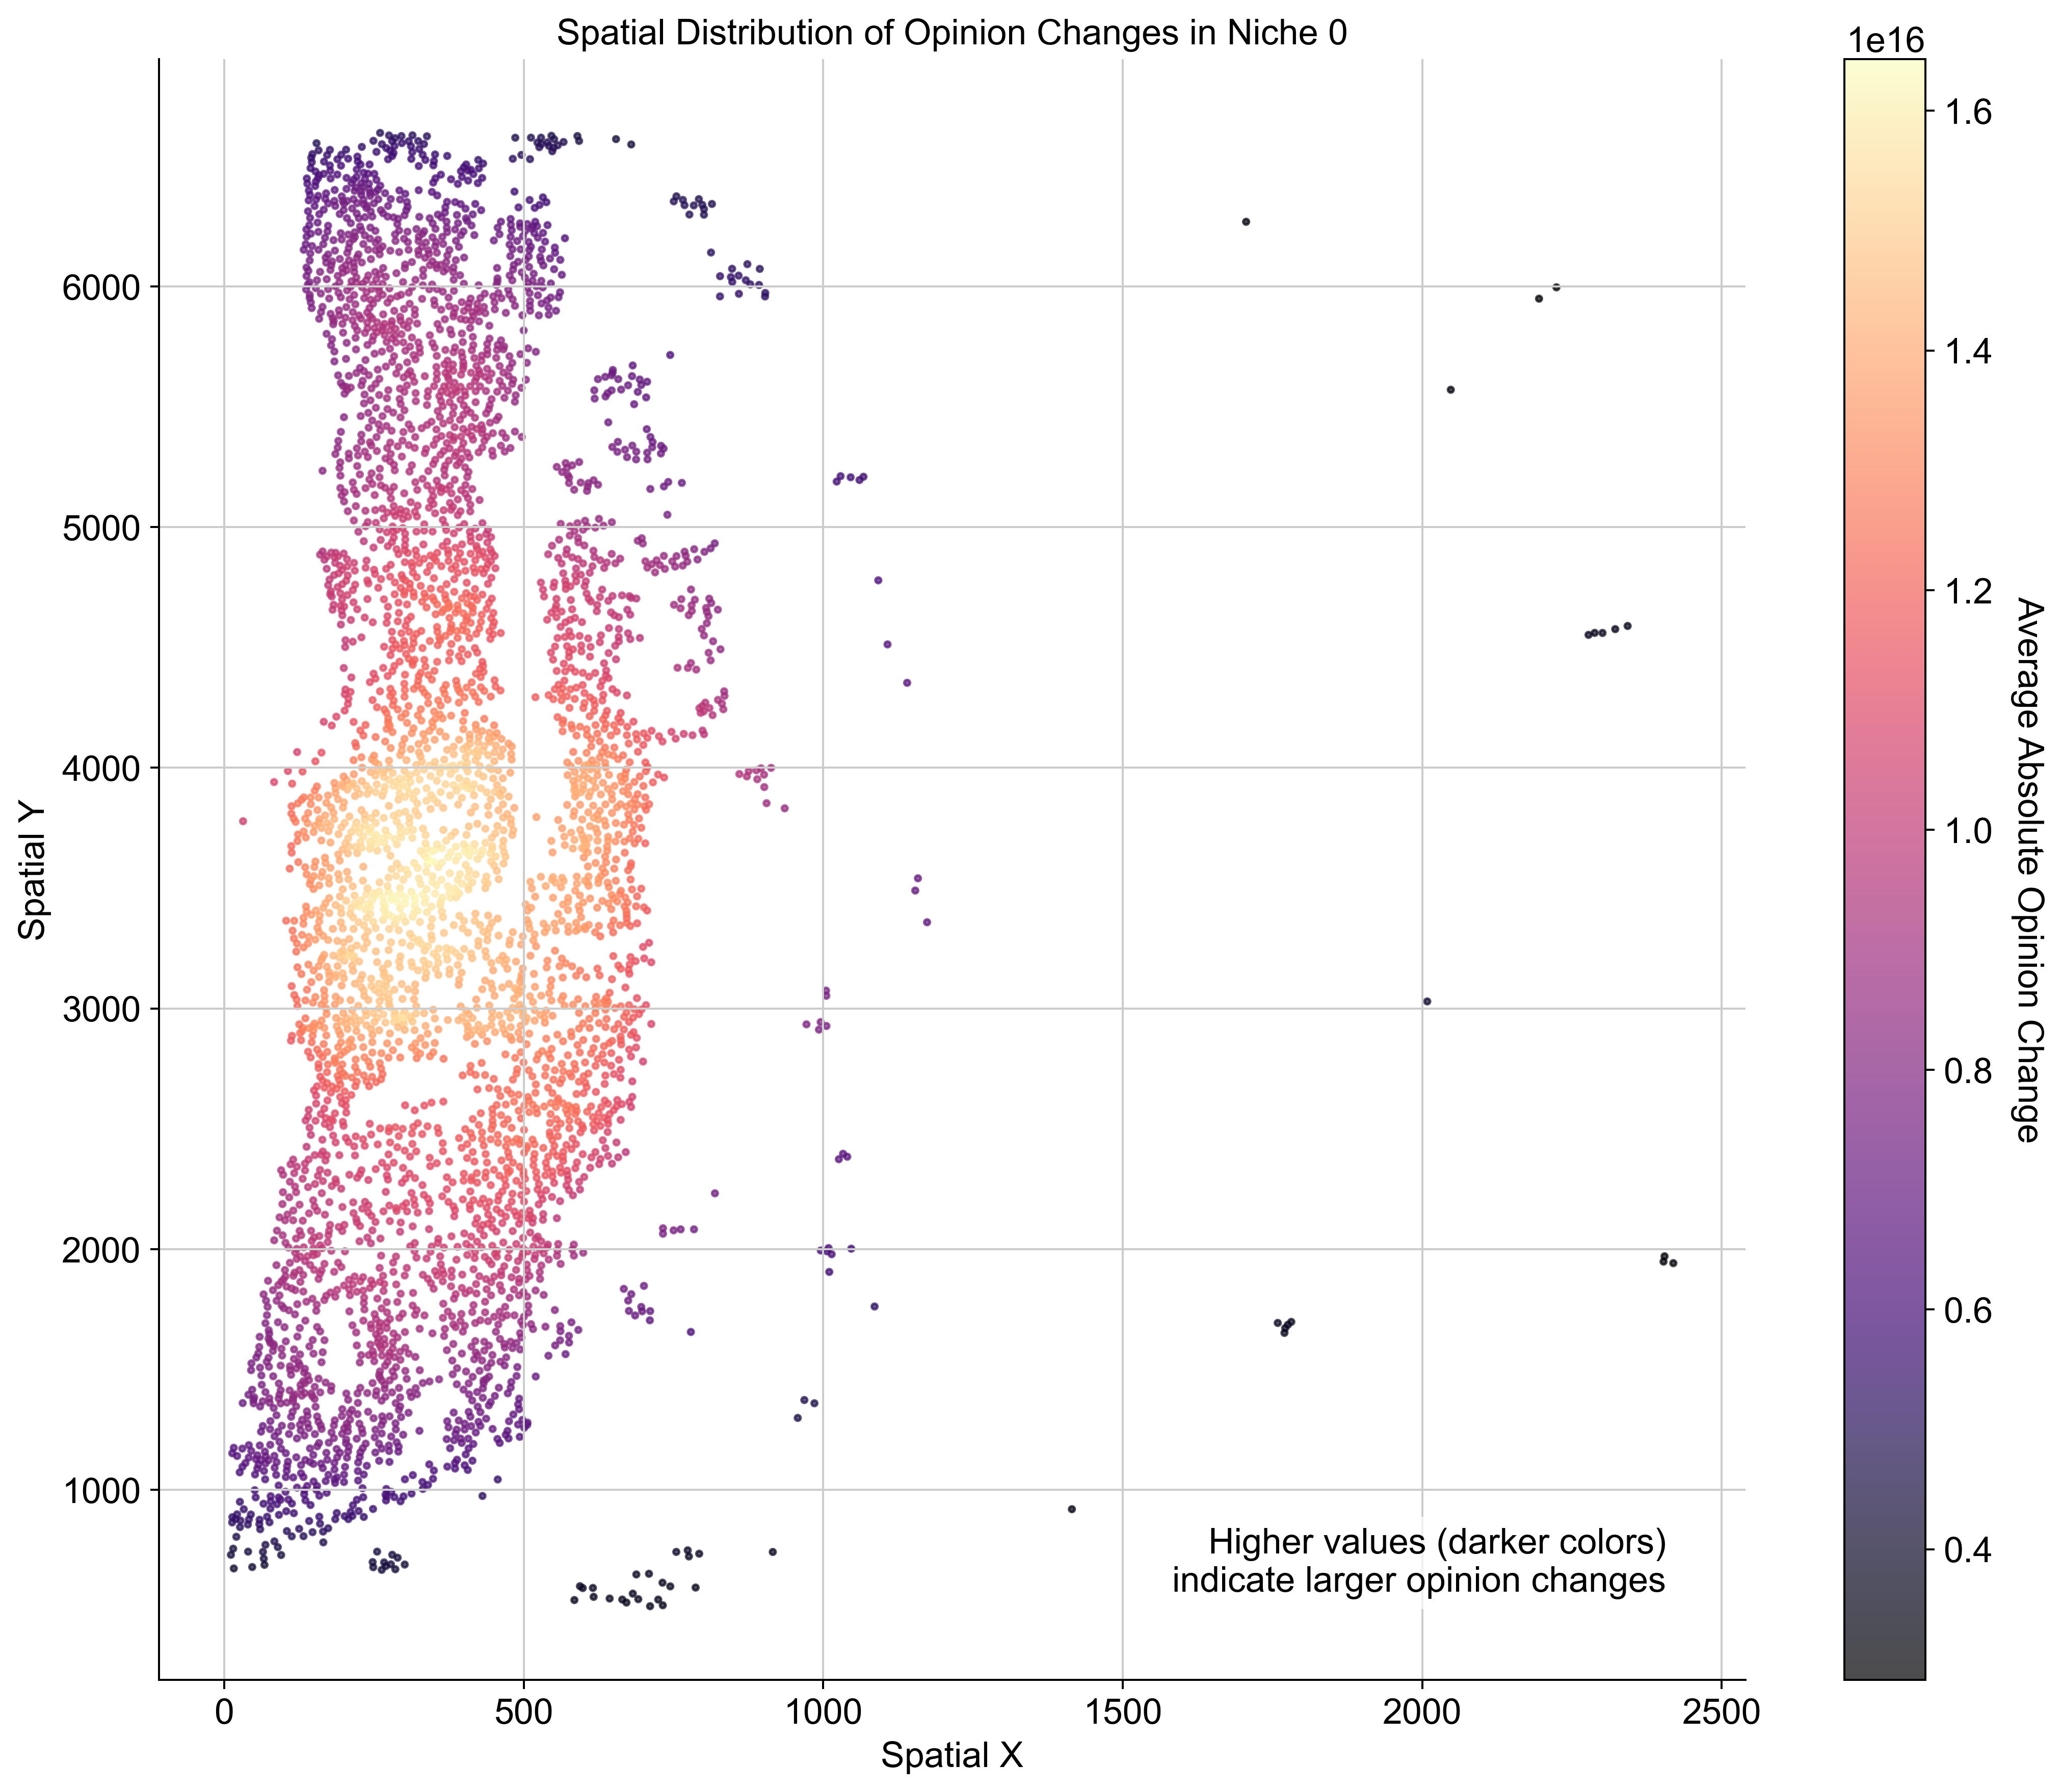

Average opinion change: 10556518363360916.0000
Maximum opinion change: 16429474352304374.0000
Minimum opinion change: 2909493978843159.0000


In [13]:
def create_spatial_opinion_change_map(initial_opinions, final_opinions, adata, niche_label):
    """
    Create a Spatial Opinion Change Map visualization.

    :param initial_opinions: DataFrame of initial cell opinions
    :param final_opinions: DataFrame of final cell opinions
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche being analyzed
    """
    # Calculate the absolute opinion change
    opinion_change = (final_opinions - initial_opinions).abs().mean(axis=1)

    # Get cells belonging to the specified niche
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label]

    # Ensure the opinion change index matches the niche cells
    opinion_change = opinion_change.loc[niche_cells.obs_names]

    # Get spatial coordinates
    spatial_coords = niche_cells.obsm['spatial']

    # Create a custom colormap (you can adjust these colors as needed)
    colors = ['#FEF001', '#F3DD01', '#E7CA02', '#DBB702', '#CFA403', '#C49103', '#B87E04', '#AC6B04', '#A05905', '#944605', '#893406', '#7D2206', '#710F07', '#660007']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    scatter = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1],
                         c=opinion_change,
                         cmap='magma',
                         s=5,  # Size of the points
                         alpha=0.7)  # Transparency of the points

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Absolute Opinion Change', rotation=270, labelpad=20)

    # Set title and labels
    plt.title(f'Spatial Distribution of Opinion Changes in Niche {niche_label}')
    plt.xlabel('Spatial X')
    plt.ylabel('Spatial Y')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a text annotation explaining the color scale
    plt.text(0.95, 0.05, 'Higher values (darker colors)\nindicate larger opinion changes',
             transform=ax.transAxes, ha='right', va='bottom',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Average opinion change: {opinion_change.mean():.4f}")
    print(f"Maximum opinion change: {opinion_change.max():.4f}")
    print(f"Minimum opinion change: {opinion_change.min():.4f}")

# Example usage
niche_label = "0"  # Replace with the desired niche label
create_spatial_opinion_change_map(initial_opinions, final_opinions, adata, niche_label)

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


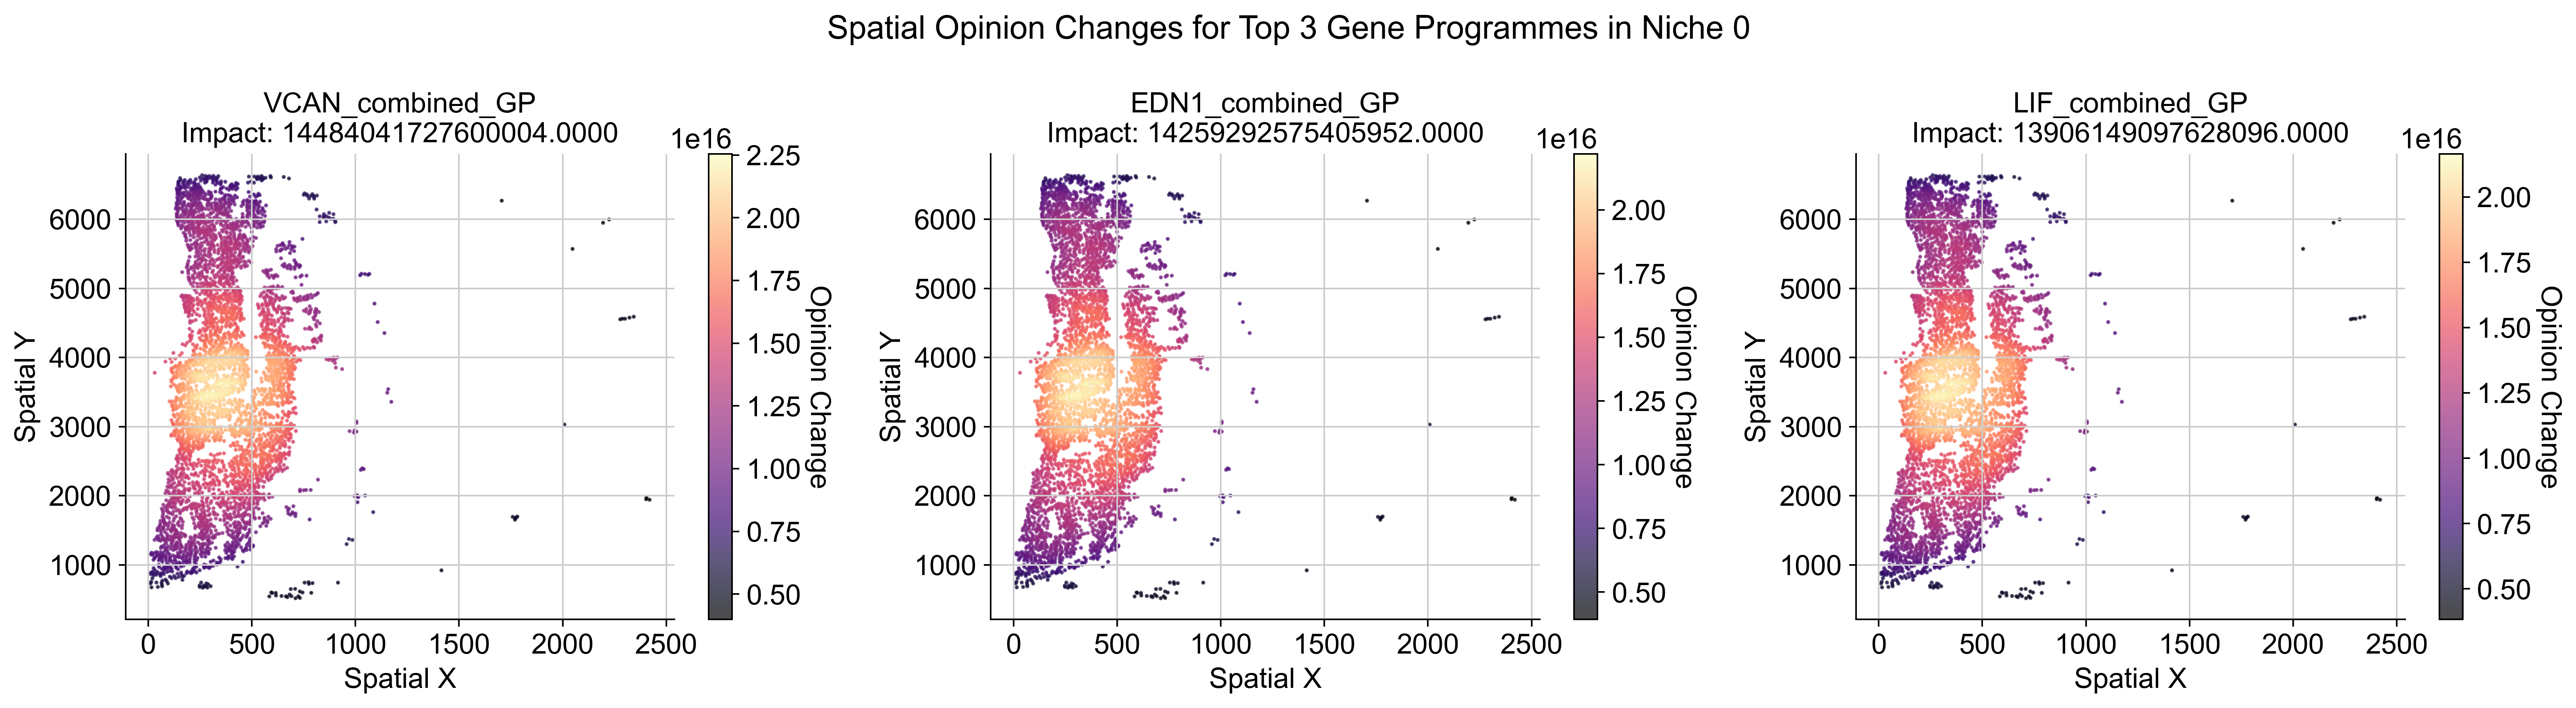

Top 3 Gene Programmes by Average Impact:

VCAN_combined_GP:
  Average impact: 14484041727600004.0000
  Max positive change: 22542014697212980.0000
  Max negative change: 3991963140358525.5000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)

EDN1_combined_GP:
  Average impact: 14259292575405952.0000
  Max positive change: 22192229819312492.0000
  Max negative change: 3930019773437761.5000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)

LIF_combined_GP:
  Average impact: 13906149097628096.0000
  Max positive change: 21642620424591596.0000
  Max negative change: 3832689498534548.0000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)


In [15]:
def visualize_top_gp_spatial_changes(initial_opinions, final_opinions, adata, niche_label, top_n=3):
    """
    Visualize spatial opinion changes for top gene programmes in a niche.

    :param initial_opinions: DataFrame of initial cell opinions
    :param final_opinions: DataFrame of final cell opinions
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche being analyzed
    :param top_n: Number of top gene programmes to visualize (default 3)
    """
    # Calculate opinion changes
    opinion_change = final_opinions - initial_opinions

    # Get cells belonging to the specified niche
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label]

    # Ensure the opinion change index matches the niche cells
    opinion_change = opinion_change.loc[niche_cells.obs_names]

    # Calculate the average absolute change for each gene programme
    gp_impact = opinion_change.abs().mean()

    # Get the top N gene programmes
    top_gps = gp_impact.nlargest(top_n)

    # Get spatial coordinates
    spatial_coords = niche_cells.obsm['spatial']

    # Create a custom colormap
    colors = ['#FEF001', '#F3DD01', '#E7CA02', '#DBB702', '#CFA403', '#C49103', '#B87E04', '#AC6B04', '#A05905', '#944605', '#893406', '#7D2206', '#710F07', '#660007']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

    # Create a grid of subplots
    fig, axes = plt.subplots(1, top_n, figsize=(6*top_n, 5), squeeze=False)
    fig.suptitle(f'Spatial Opinion Changes for Top {top_n} Gene Programmes in Niche {niche_label}', fontsize=16)

    for i, (gp, impact) in enumerate(top_gps.items()):
        ax = axes[0, i]
        
        # Plot spatial distribution of opinion changes for this gene programme
        scatter = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1],
                             c=opinion_change[gp],
                             cmap='magma',
                             s=1,  # Size of the points
                             alpha=0.7)  # Transparency of the points

        # Add a color bar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Opinion Change', rotation=270, labelpad=15)

        # Set title and labels
        ax.set_title(f'{gp}\nImpact: {impact:.4f}')
        ax.set_xlabel('Spatial X')
        ax.set_ylabel('Spatial Y')

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"Top {top_n} Gene Programmes by Average Impact:")
    for gp, impact in top_gps.items():
        changes = opinion_change[gp]
        print(f"\n{gp}:")
        print(f"  Average impact: {impact:.4f}")
        print(f"  Max positive change: {changes.max():.4f}")
        print(f"  Max negative change: {changes.min():.4f}")
        print(f"  Cells with positive change: {(changes > 0).sum()} ({(changes > 0).mean()*100:.2f}%)")
        print(f"  Cells with negative change: {(changes < 0).sum()} ({(changes < 0).mean()*100:.2f}%)")

# Example usage
niche_label = "0"  # Replace with the desired niche label
visualize_top_gp_spatial_changes(initial_opinions, final_opinions, adata, niche_label)

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


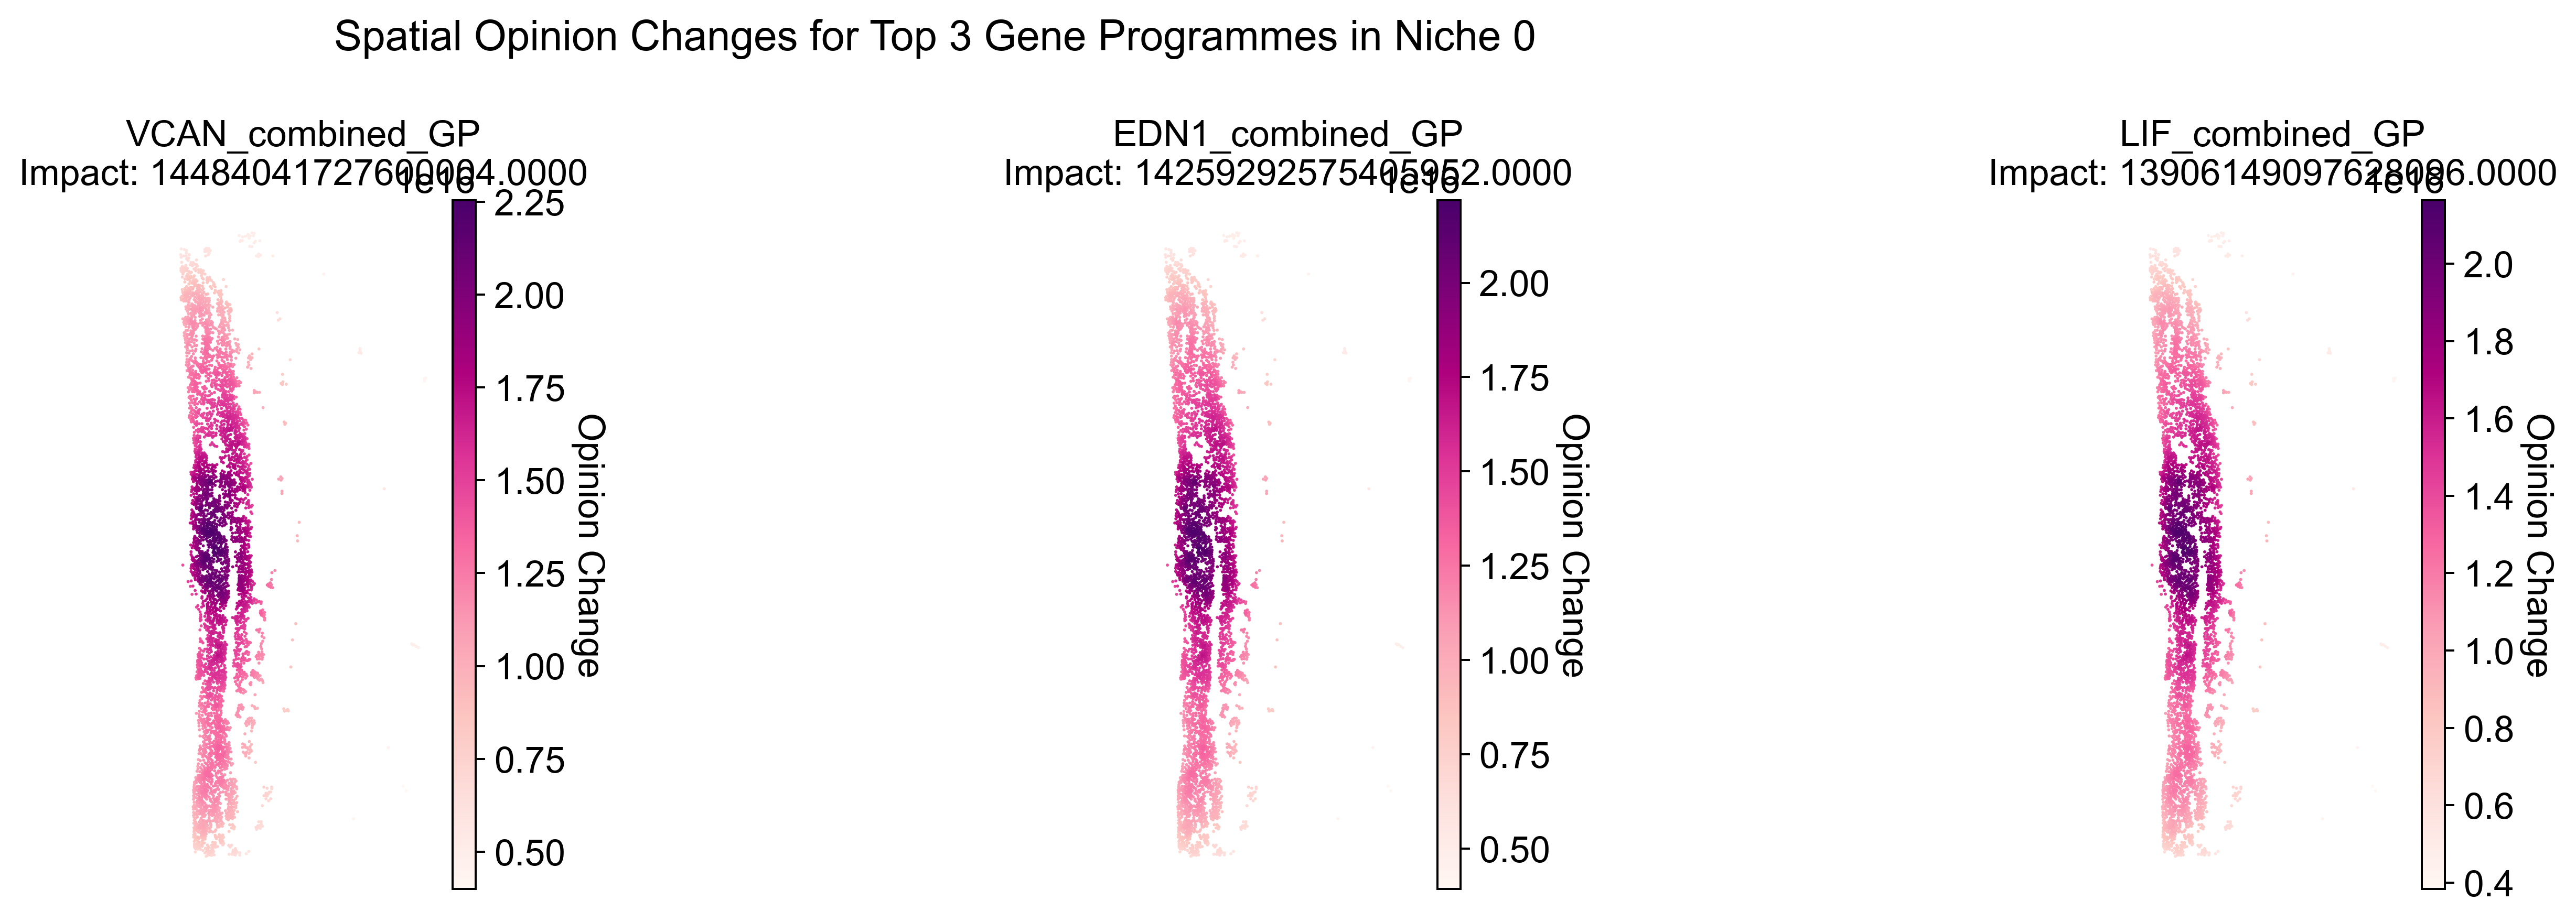

Top 3 Gene Programmes by Average Impact:

VCAN_combined_GP:
  Average impact: 14484041727600004.0000
  Max positive change: 22542014697212980.0000
  Max negative change: 3991963140358525.5000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)

EDN1_combined_GP:
  Average impact: 14259292575405952.0000
  Max positive change: 22192229819312492.0000
  Max negative change: 3930019773437761.5000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)

LIF_combined_GP:
  Average impact: 13906149097628096.0000
  Max positive change: 21642620424591596.0000
  Max negative change: 3832689498534548.0000
  Cells with positive change: 4354 (100.00%)
  Cells with negative change: 0 (0.00%)


In [16]:
def plot_opinion_changes_spatial(initial_opinions, final_opinions, adata, niche_label, sample_key, top_n=3):
    """
    Plot spatial distribution of opinion changes for top gene programmes using Squidpy.

    :param initial_opinions: DataFrame of initial cell opinions
    :param final_opinions: DataFrame of final cell opinions
    :param adata: AnnData object containing the dataset
    :param niche_label: Label of the niche being analyzed
    :param sample_key: Key in adata.obs for the sample information
    :param top_n: Number of top gene programmes to visualize (default 3)
    """
    # Calculate opinion changes
    opinion_change = final_opinions - initial_opinions

    # Get cells belonging to the specified niche
    niche_cells = adata[adata.obs['latent_leiden_0.4'] == niche_label].copy()

    # Ensure the opinion change index matches the niche cells
    opinion_change = opinion_change.loc[niche_cells.obs_names]

    # Calculate the average absolute change for each gene programme
    gp_impact = opinion_change.abs().mean()

    # Get the top N gene programmes
    top_gps = gp_impact.nlargest(top_n)

    # Add opinion change data to the AnnData object
    for gp in top_gps.index:
        niche_cells.obs[f'opinion_change_{gp}'] = opinion_change[gp]

    # Create a figure with subplots for each top gene programme
    fig, axes = plt.subplots(1, top_n, figsize=(6*top_n, 5), squeeze=False)
    fig.suptitle(f'Spatial Opinion Changes for Top {top_n} Gene Programmes in Niche {niche_label}', fontsize=16)

    for i, (gp, impact) in enumerate(top_gps.items()):
        ax = axes[0, i]
        
        # Plot spatial distribution of opinion changes for this gene programme
        sc.pl.spatial(adata=niche_cells,
                      color=f'opinion_change_{gp}',
                      spot_size=50,  # Adjust this value as needed
                      title=f'{gp}\nImpact: {impact:.4f}',
                      ax=ax,
                      show=False,
                      colorbar_loc='right',
                      frameon=False,
                      size=0.6)

        # Customize colorbar
        cbar = ax.collections[-1].colorbar
        cbar.set_label('Opinion Change', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"Top {top_n} Gene Programmes by Average Impact:")
    for gp, impact in top_gps.items():
        changes = opinion_change[gp]
        print(f"\n{gp}:")
        print(f"  Average impact: {impact:.4f}")
        print(f"  Max positive change: {changes.max():.4f}")
        print(f"  Max negative change: {changes.min():.4f}")
        print(f"  Cells with positive change: {(changes > 0).sum()} ({(changes > 0).mean()*100:.2f}%)")
        print(f"  Cells with negative change: {(changes < 0).sum()} ({(changes < 0).mean()*100:.2f}%)")

# Example usage
niche_label = "0"  # Replace with the desired niche label
sample_key = "sample"  # Replace with the actual key in your adata.obs for sample information

plot_opinion_changes_spatial(initial_opinions, final_opinions, adata, niche_label, sample_key)

### Classify genes into families and superfamilies

In [ ]:
response = mart.search({
    'filters': {
        'external_gene_name': genes
    },
    'attributes': [
        'external_gene_name',
        'gene_biotype',
        'interpro_description', 
        'go_id',               
        'goslim_goa_description' 
    ]
})

classification = {}
seen_genes = set() 

for line in response.iter_lines():
    line = line.decode('utf-8')
    gene_name, gene_biotype, interpro_description, go_id, go_slim_description = line.split('\t')

    if gene_name in seen_genes: 
        continue

    if not interpro_description:
        interpro_description = 'Unknown Family'
    if not go_slim_description:
        go_slim_description = 'Unknown Pathway'

    if go_slim_description not in classification:
        classification[go_slim_description] = {}

    classification[go_slim_description][interpro_description] = [gene_name]  
    seen_genes.add(gene_name)

gene_weights = dict(zip(genes, weights)) 

data = []
for pathway, families in classification.items():
    for family, genes_list in families.items():
        for gene in genes_list:
            weight = gene_weights.get(gene) 
            data.append([pathway, family, gene, weight])

df = pd.DataFrame(data, columns=['Pathway', 'Family', 'Gene', 'Gene Weight'])

df_filtered = df.dropna(subset=['Gene Weight'])
df_filtered.head()

### Visualise genes and gene weights as a sunburst plot for easier interpretability

In [ ]:
fig = px.sunburst(df_filtered, 
                  path=['Pathway', 'Family', 'Gene'], 
                  color='Gene Weight',
                  color_continuous_scale='RdYlBu_r')

fig.update_layout(coloraxis_colorbar=dict(
    title="Gene Importance Weight",
    tickvals=[min(df_filtered['Gene Weight']), max(df_filtered['Gene Weight'])],
    tickmode='array' 
))

fig.update_layout(
    width=1000,
    height=1000
)

fig.update_traces(
    textinfo="label",
    insidetextfont=dict(size=15)
)

fig.show()